In [1]:
#!pip install scikeras transformers pandas matplotlib

In [2]:
#!pip install pandas numpy matplotlib scikit-learn imbalanced-learn tensorflow transformers torch


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
import warnings
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification,DistilBertForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
import gc
# Aplicar LabelEncoder
import warnings
import time
import datetime
#from google.colab import drive
#drive.mount('/content/drive')

pd.set_option('display.float_format', lambda x: '%.3f' %x)
warnings.filterwarnings("ignore")
#Estava retornando o erro abaixo:
#RuntimeError: Failed to import transformers.models.distilbert.modeling_tf_distilbert because of the following error (look up to see its traceback):
#No module named 'keras.saving.hdf5_format'

#Solução:
#Comentar a linha "from keras.saving.hdf5_format import save_attributes_to_hdf5_group" dentro do caminho:
#C:\Users\Thiago\anaconda3\Lib\site-packages\transformers arquivo: modeling_tf_utils.py

2023-11-25 23:45:17.747579: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-25 23:45:17.769100: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-25 23:45:17.769123: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-25 23:45:17.769135: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 23:45:17.774154: I tensorflow/core/platform/cpu_feature_g

In [4]:
##### Memory reduction script 1

def sd(col, max_loss_limit=0.001, avg_loss_limit=0.001, na_loss_limit=0, n_uniq_loss_limit=0, fillna=0):
    """
    max_loss_limit - don't allow any float to lose precision more than this value. Any values are ok for GBT algorithms as long as you don't unique values.
                     See https://en.wikipedia.org/wiki/Half-precision_floating-point_format#Precision_limitations_on_decimal_values_in_[0,_1]
    avg_loss_limit - same but calculates avg throughout the series.
    na_loss_limit - not really useful.
    n_uniq_loss_limit - very important parameter. If you have a float field with very high cardinality you can set this value to something like n_records * 0.01 in order to allow some field relaxing.
    """
    is_float = str(col.dtypes)[:5] == 'float'
    na_count = col.isna().sum()
    n_uniq = col.nunique(dropna=False)
    try_types = ['float16', 'float32']

    if na_count <= na_loss_limit:
        try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

    for type in try_types:
        col_tmp = col

        # float to int conversion => try to round to minimize casting error
        if is_float and (str(type)[:3] == 'int'):
            col_tmp = col_tmp.copy().fillna(fillna).round()

        col_tmp = col_tmp.astype(type)
        max_loss = (col_tmp - col).abs().max()
        avg_loss = (col_tmp - col).abs().mean()
        na_loss = np.abs(na_count - col_tmp.isna().sum())
        n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

        if max_loss <= max_loss_limit and avg_loss <= avg_loss_limit and na_loss <= na_loss_limit and n_uniq_loss <= n_uniq_loss_limit:
            return col_tmp

    # field can't be converted
    return col

##### Memory reduction script 2

def reduce_mem_usage_sd(df, deep=True, verbose=False, obj_to_cat=False):
    numerics = ['int16', 'uint16', 'int32', 'uint32', 'int64', 'uint64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes

        # collect stats
        na_count = df[col].isna().sum()
        n_uniq = df[col].nunique(dropna=False)

        # numerics
        if col_type in numerics:
            df[col] = sd(df[col])

        # strings
        if (col_type == 'object') and obj_to_cat:
            df[col] = df[col].astype('category')

        if verbose:
            print(f'Column {col}: {col_type} -> {df[col].dtypes}, na_count={na_count}, n_uniq={n_uniq}')
        new_na_count = df[col].isna().sum()
        if (na_count != new_na_count):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost na values. Before: {na_count}, after: {new_na_count}')
        new_n_uniq = df[col].nunique(dropna=False)
        if (n_uniq != new_n_uniq):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost unique values. Before: {n_uniq}, after: {new_n_uniq}')

    end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    if verbose:
        print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

##### Memory reduction script 3
# https://www.kaggle.com/kyakovlev/ieee-data-minification
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2 # just added
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

##### Functions
# 1st function: to graph time series based on TransactionDT vs the variable selected

def scatter(column):
    fr,no_fr = (train[train['isFraud'] == 1], train[train['isFraud'] == 0])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
    ax1.title.set_text('Histogram ' + column + ' when isFraud == 0')
    ax1.set_ylim(train[column].min() - 1,train[column].max() + 1)
    ax1.scatter(x = no_fr['TransactionDT'], y = no_fr[column], color = 'blue', marker='o')
    ax2.title.set_text('Histogram ' + column + ' when isFraud == 1')
    ax2.set_ylim(train[column].min() - 1,train[column].max() + 1)
    ax2.scatter(x = fr['TransactionDT'], y = fr[column], color = 'red', marker='o')
    plt.show()

# 2nd function: to show a ranking of pearson correlation with the variable selected

def corr(data,column):
    print('Correlation with ' + column)
    print(train[data].corrwith(data[column]).abs().sort_values(ascending = False)[1:])

# 3rd function: to reduce the groups based on Nans agroupation and pearson correlation
def reduce(groups):
    result = list()
    for values in groups:
        maxval = 0
        val = values[0]
        for value in values:
            unique_values = data[value].nunique()
            if unique_values > maxval:
                maxval = unique_values
                val = value
        result.append(value)
    return result

# 4th function: to sort each column in ascending order based on its number

def order_finalcolumns(final_Xcolumns):
    return sorted(final_Xcolumns, key=lambda x: int("".join([i for i in x if i.isdigit()])))


In [5]:
#Carregando os dados
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
#Efetuar o merge pela coluna TransactionID
data = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [6]:
%%time
#Tratamento para melhorar a coluna DeviceInfo
data.loc[data['DeviceInfo'].str.contains('SM', na=False), 'DeviceInfo'] = 'Samsung'
data.loc[data['DeviceInfo'].str.contains('SAMSUNG', na=False), 'DeviceInfo'] = 'Samsung'
data.loc[data['DeviceInfo'].str.contains('GT-', na=False), 'DeviceInfo'] = 'Samsung'
data.loc[data['DeviceInfo'].str.contains('Moto G', na=False), 'DeviceInfo'] = 'Motorola'
data.loc[data['DeviceInfo'].str.contains('Moto', na=False), 'DeviceInfo'] = 'Motorola'
data.loc[data['DeviceInfo'].str.contains('moto', na=False), 'DeviceInfo'] = 'Motorola'
data.loc[data['DeviceInfo'].str.contains('LG-', na=False), 'DeviceInfo'] = 'LG'
data.loc[data['DeviceInfo'].str.contains('rv:', na=False), 'DeviceInfo'] = 'RV'
data.loc[data['DeviceInfo'].str.contains('HUAWEI', na=False), 'DeviceInfo'] = 'Huawei'
data.loc[data['DeviceInfo'].str.contains('ALE-', na=False), 'DeviceInfo'] = 'Huawei'
data.loc[data['DeviceInfo'].str.contains('-L', na=False), 'DeviceInfo'] = 'Huawei'
data.loc[data['DeviceInfo'].str.contains('Blade', na=False), 'DeviceInfo'] = 'ZTE'
data.loc[data['DeviceInfo'].str.contains('BLADE', na=False), 'DeviceInfo'] = 'ZTE'
data.loc[data['DeviceInfo'].str.contains('Linux', na=False), 'DeviceInfo'] = 'Linux'
data.loc[data['DeviceInfo'].str.contains('XT', na=False), 'DeviceInfo'] = 'Sony'
data.loc[data['DeviceInfo'].str.contains('HTC', na=False), 'DeviceInfo'] = 'HTC'
data.loc[data['DeviceInfo'].str.contains('ASUS', na=False), 'DeviceInfo'] = 'Asus'
#Tratamento para unificar e-mail por provider.
data.loc[data['P_emaildomain'].str.contains('gmail', na=False), 'P_emaildomain'] = 'Google'
data.loc[data['P_emaildomain'].str.contains('hotmail|outlook|msn|live|', na=False), 'P_emaildomain'] = 'Microsoft'
data.loc[data['P_emaildomain'].str.contains('yahoo|ymail|att|bellsouth', na=False), 'P_emaildomain'] = 'Yahoo'
data.loc[data['P_emaildomain'].str.contains('icloud|me|mac', na=False), 'P_emaildomain'] = 'Apple'
data.loc[data['P_emaildomain'].str.contains('aol|aim', na=False), 'P_emaildomain'] = 'AOL'
data.loc[data['P_emaildomain'].str.contains('embarqmail|centurylink', na=False), 'P_emaildomain'] = 'CenturyLink'
data.loc[data['P_emaildomain'].str.contains('frontier', na=False), 'P_emaildomain'] = 'Frontier'
data.loc[data['P_emaildomain'].str.contains('netzero', na=False), 'P_emaildomain'] = 'Netzero'
data.loc[data['P_emaildomain'].str.contains('cfl|sc.rr|twc', na=False), 'P_emaildomain'] = 'Spectrum'
data.loc[data['P_emaildomain'].str.contains('protonmail|ptd|servicios|roadrunner|juno|windstream|scranton', na=False), 'P_emaildomain'] = 'Others'
data.loc[data['P_emaildomain'].str.contains('q.com|web|suddenlink|cableone|prodigy|gmx', na=False), 'P_emaildomain'] = 'Others'

data.loc[data['R_emaildomain'].str.contains('gmail', na=False), 'R_emaildomain'] = 'Google'
data.loc[data['R_emaildomain'].str.contains('hotmail|outlook|msn|live|', na=False), 'R_emaildomain'] = 'Microsoft'
data.loc[data['R_emaildomain'].str.contains('yahoo|ymail|att|bellsouth', na=False), 'R_emaildomain'] = 'Yahoo'
data.loc[data['R_emaildomain'].str.contains('icloud|me|mac', na=False), 'R_emaildomain'] = 'Apple'
data.loc[data['R_emaildomain'].str.contains('aol|aim', na=False), 'R_emaildomain'] = 'AOL'
data.loc[data['R_emaildomain'].str.contains('embarqmail|centurylink', na=False), 'R_emaildomain'] = 'CenturyLink'
data.loc[data['R_emaildomain'].str.contains('frontier', na=False), 'R_emaildomain'] = 'Frontier'
data.loc[data['R_emaildomain'].str.contains('netzero', na=False), 'R_emaildomain'] = 'Netzero'
data.loc[data['R_emaildomain'].str.contains('cfl|sc.rr|twc', na=False), 'R_emaildomain'] = 'Spectrum'
data.loc[data['R_emaildomain'].str.contains('protonmail|ptd|servicios|roadrunner|juno|windstream|scranton', na=False), 'R_emaildomain'] = 'Others'
data.loc[data['R_emaildomain'].str.contains('q.com|web|suddenlink|cableone|prodigy|gmx', na=False), 'R_emaildomain'] = 'Others'

#Temos o TransactionDT que é uma data aleatorio no tempo, irei transformar em Dia,Mes e Ano para facilitar a analise.
#data['TransactionDT'] = pd.to_datetime(data['TransactionDT']) - Não ficou bom.

# Converter a coluna de datas para componentes numéricos
startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
data['TransactionDT'] = data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
data.insert(4, 'TransHour', data['TransactionDT'].dt.hour)
data.insert(5, 'TransDay', data['TransactionDT'].dt.day)
data.insert(6, 'TransMonth', data['TransactionDT'].dt.month)
data.insert(7, 'TransWeek', data['TransactionDT'].dt.isocalendar().week)
data = data.drop(columns=['TransactionDT'])
# Criar uma nova coluna representando os grupos de duas em duas horas
data['HourGroup'] = (data['TransHour'] // 2) * 2


CPU times: user 3.12 s, sys: 88.7 ms, total: 3.21 s
Wall time: 3.21 s


In [7]:
#data = data.replace(np.nan, 0)
#Efetuo redução de memoria.
data = reduce_mem_usage_sd(data, verbose=True)

Column TransactionID: int64 -> int32, na_count=0, n_uniq=590540
Column isFraud: int64 -> int8, na_count=0, n_uniq=2
Column TransactionAmt: float64 -> float32, na_count=0, n_uniq=20902
Column TransHour: int32 -> int8, na_count=0, n_uniq=24
Column TransDay: int32 -> int8, na_count=0, n_uniq=31
Column TransMonth: int32 -> int8, na_count=0, n_uniq=7
Column TransWeek: UInt32 -> UInt32, na_count=0, n_uniq=27
Column ProductCD: object -> object, na_count=0, n_uniq=5
Column card1: int64 -> int16, na_count=0, n_uniq=13553
Column card2: float64 -> float16, na_count=8933, n_uniq=501
Column card3: float64 -> float16, na_count=1565, n_uniq=115
Column card4: object -> object, na_count=1577, n_uniq=5
Column card5: float64 -> float16, na_count=4259, n_uniq=120
Column card6: object -> object, na_count=1571, n_uniq=5
Column addr1: float64 -> float16, na_count=65706, n_uniq=333
Column addr2: float64 -> float16, na_count=65706, n_uniq=75
Column dist1: float64 -> float32, na_count=352271, n_uniq=2652
Column

Column id_24: float64 -> float16, na_count=585793, n_uniq=13
Column id_25: float64 -> float16, na_count=585408, n_uniq=342
Column id_26: float64 -> float16, na_count=585377, n_uniq=96
Column id_27: object -> object, na_count=585371, n_uniq=3
Column id_28: object -> object, na_count=449562, n_uniq=3
Column id_29: object -> object, na_count=449562, n_uniq=3
Column id_30: object -> object, na_count=512975, n_uniq=76
Column id_31: object -> object, na_count=450258, n_uniq=131
Column id_32: float64 -> float16, na_count=512954, n_uniq=5
Column id_33: object -> object, na_count=517251, n_uniq=261
Column id_34: object -> object, na_count=512735, n_uniq=5
Column id_35: object -> object, na_count=449555, n_uniq=3
Column id_36: object -> object, na_count=449555, n_uniq=3
Column id_37: object -> object, na_count=449555, n_uniq=3
Column id_38: object -> object, na_count=449555, n_uniq=3
Column DeviceType: object -> object, na_count=449730, n_uniq=3
Column DeviceInfo: object -> object, na_count=4718

In [8]:
columns= list(data.columns[:20])
columns

['TransactionID',
 'isFraud',
 'TransactionAmt',
 'TransHour',
 'TransDay',
 'TransMonth',
 'TransWeek',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain']

In [9]:
for col in columns:
    print(f'{col} NaNs: {data[col].isna().sum()} | {data[col].isna().sum()/data.shape[0]:.2%}')

TransactionID NaNs: 0 | 0.00%
isFraud NaNs: 0 | 0.00%
TransactionAmt NaNs: 0 | 0.00%
TransHour NaNs: 0 | 0.00%
TransDay NaNs: 0 | 0.00%
TransMonth NaNs: 0 | 0.00%
TransWeek NaNs: 0 | 0.00%
ProductCD NaNs: 0 | 0.00%
card1 NaNs: 0 | 0.00%
card2 NaNs: 8933 | 1.51%
card3 NaNs: 1565 | 0.27%
card4 NaNs: 1577 | 0.27%
card5 NaNs: 4259 | 0.72%
card6 NaNs: 1571 | 0.27%
addr1 NaNs: 65706 | 11.13%
addr2 NaNs: 65706 | 11.13%
dist1 NaNs: 352271 | 59.65%
dist2 NaNs: 552913 | 93.63%
P_emaildomain NaNs: 94456 | 15.99%
R_emaildomain NaNs: 453249 | 76.75%


In [10]:
# If we look closely to % NaNs data, most of them have low number of missing information. We are keeping all the columns where % NaNs < 0.7

final_transactioncolumns = list()
for col in columns:
    if data[col].isna().sum()/data.shape[0] < 0.7:
        final_transactioncolumns.append(col)
print('Final Transaction columns:',final_transactioncolumns)

Final Transaction columns: ['TransactionID', 'isFraud', 'TransactionAmt', 'TransHour', 'TransDay', 'TransMonth', 'TransWeek', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain']


In [11]:
##### Based on pearson correlation, we grouped together the columns with corr > 0.7

reduce_groups = [['C1','C11','C2','C6','C8','C4','C10','C14','C12','C7','C13'], ['C3'], ['C5','C9']]

result = reduce(reduce_groups)
print('Final C columns:',result)
final_ccolumns = result


Final C columns: ['C13', 'C3', 'C9']


In [12]:
reduce_groups = [['D3','D7','D5'], ['D8'], ['D9']]

result = reduce(reduce_groups)
print('Final D columns:',result)
final_dcolumns = result

Final D columns: ['D5', 'D8', 'D9']


In [13]:
final_vcolumns = list()
reduce_groups = ['V1'], ['V2','V3'], ['V4','V5'], ['V6','V7'], ['V8','V9']

result = reduce(reduce_groups)
final_vcolumns.extend(result)

In [14]:
reduce_groups = [['V12','V13'], ['V14'], ['V15','V16','V33','V34','V31','V32','V21','V22','V17','V18'], ['V19','V20'],['V23','V24'],['V25','V26'],['V27','V28'],['V29','V30']]

result = reduce(reduce_groups)
final_vcolumns.extend(result)

In [15]:
reduce_groups = [['V35','V36'], ['V37','V38'], ['V39','V40','V42','V43','V50','V51','V52'], ['V41'], ['V44','V45'],['V46','V47'],['V48','V49']]

result = reduce(reduce_groups)
final_vcolumns.extend(result)

In [16]:
reduce_groups = [['V53','V54'], ['V55','V56'], ['V57','V58','V71','V73','V72','V74','V63','V59','V64','V60'],['V61','V62'],['V65'],
                ['V66','V67'],['V68'], ['V69','V70']]

result = reduce(reduce_groups)
final_vcolumns.extend(result)
print('Final V_Group4 columns:',result)

Final V_Group4 columns: ['V54', 'V56', 'V60', 'V62', 'V65', 'V67', 'V68', 'V70']


In [17]:
reduce_groups = [['V95','V101'],['V96','V102','V97','V99','V100','V103'],['V98'],['V104','V106','V105'],['V108','V110','V114','V109','V111','V113','V112','V115','V116'],
                ['V117','V119','V118'],['V120','V122','V121'],['V123','V125','V124'],['V126','V128','V132'],['V127','V133','V134'],['V129','V131','V130'],
                ['V135','V137','V136']]

result = reduce(reduce_groups)
final_vcolumns.extend(result)
print('Final V_Group6 columns:',result)

Final V_Group6 columns: ['V101', 'V103', 'V98', 'V105', 'V116', 'V118', 'V121', 'V124', 'V132', 'V134', 'V130', 'V136']


In [18]:
reduce_groups = [['V138'],['V139','V140'],['V141','V142'],['V143','V159','V150','V151','V165','V144','V145','V160','V152','V164','V166'],['V146','V147'],
                ['V148','V155','V149','V153','V154','V156','V157','V158'],['V161','V163','V162']]

result = reduce(reduce_groups)
final_vcolumns.extend(result)
print('Final V_Group7 columns:',result)

Final V_Group7 columns: ['V138', 'V140', 'V142', 'V166', 'V147', 'V158', 'V162']


In [19]:
reduce_groups = ['V167','V176','V199','V179','V190','V177','V186','V168','V172','V178','V196','V191','V204','V213','V207','V173'],['V181','V183','V182',
                'V187','V192','V203','V215','V178','V193','V212','V204'],['V202','V216','V204','V214']

result = reduce(reduce_groups)
final_vcolumns.extend(result)
print('Final V_Group8 columns:',result)

Final V_Group8 columns: ['V173', 'V204', 'V214']


In [20]:
reduce_groups = [['V169'],['V170','V171','V200','V201'],['V174','V175'],['V180'],['V184','V185'],['V188','V189'],['V194','V197','V195','V198'],
                ['V208','V210','V209']]

result = reduce(reduce_groups)
final_vcolumns.extend(result)
print('Final V_Group9 columns:',result)

Final V_Group9 columns: ['V169', 'V201', 'V175', 'V180', 'V185', 'V189', 'V198', 'V209']


In [21]:
reduce_groups = [['V217','V231','V233','V228','V257','V219','V232','V246'],['V218','V229','V224','V225','V253','V243','V254','V248','V264','V261','V249','V258',
                'V267','V274','V230','V236','V247','V262','V223','V252','V260'],['V226','V263','V276','V278'], ['V235','V237'],['V240','V241'],['V242','V244'],
                ['V265','V275','V277','V268','V273'],['V269','V266']]

result = reduce(reduce_groups)
final_vcolumns.extend(result)
print('Final V_Group10 columns:',result)

Final V_Group10 columns: ['V246', 'V260', 'V278', 'V237', 'V241', 'V244', 'V273', 'V266']


In [22]:
reduce_groups = ['V220'],['V221','V222','V259','V245','V227','V255','V256'],['V234'],['V238','V239'],['V250','V251'],['V270','V272','V271']

result = reduce(reduce_groups)
final_vcolumns.extend(result)
print('Final V_Group11 columns:',result)

Final V_Group11 columns: ['V220', 'V256', 'V234', 'V239', 'V251', 'V271']


In [23]:
reduce_groups = [['V279','V293','V290','V280','V295','V294','V292','V291','V317','V307','V318'],['V284'],['V285','V287'],['V286'],['V297','V299','V298'],
                ['V302','V304','V303'],['V305'],['V306','V308','V316','V319'],['V309','V311','V312','V310'],['V320','V321']]

result = reduce(reduce_groups)
final_vcolumns.extend(result)
print('Final V_Group12 columns:',result)

Final V_Group12 columns: ['V318', 'V284', 'V287', 'V286', 'V298', 'V303', 'V305', 'V319', 'V310', 'V321']


In [24]:
reduce_groups = ['V281','V282','V283'],['V288','V289'],['V296'],['V300','V301'],['V313','V315','V314']

result = reduce(reduce_groups)
final_vcolumns.extend(result)
print('Final V_Group13 columns:',result)

Final V_Group13 columns: ['V283', 'V289', 'V296', 'V301', 'V314']


In [25]:
reduce_groups = ['V322','V324'],['V323','V326','V324','V327','V326'],['V325'],['V328','V330','V329'],['V331','V333','V332','V337'],['V334','V336','V335']

result = reduce(reduce_groups)
final_vcolumns.extend(result)
print('Final V_Group14 columns:',result)

Final V_Group14 columns: ['V324', 'V326', 'V325', 'V329', 'V337', 'V335']


In [26]:
#Utilizei uma estrategia de agrupamento por correlação de Person, quando > 0.7, para tentar maximizar o dataset
reduce_groups = ['M1'], ['M2','M3'], ['M4'], ['M5'], ['M6'], ['M7', 'M8'], ['M9']

result = reduce(reduce_groups)
print('Final M columns:',result)
final_mcolumns = result

Final M columns: ['M1', 'M3', 'M4', 'M5', 'M6', 'M8', 'M9']


In [27]:
final_ccolumns = order_finalcolumns(final_ccolumns)
final_dcolumns = order_finalcolumns(final_dcolumns)
final_mcolumns = order_finalcolumns(final_mcolumns)
final_vcolumns = order_finalcolumns(final_vcolumns)

In [28]:
##### Final columns

print(f'Final Transaction columns ({len(final_transactioncolumns)}): {final_transactioncolumns}')
print(' ')
print(f'Final C columns ({len(final_ccolumns)}): {final_ccolumns}')
print(' ')
print(f'Final D columns ({len(final_dcolumns)}): {final_dcolumns}')
print(' ')
print(f'Final M columns ({len(final_mcolumns)}): {final_mcolumns}')
print(' ')
print(f'Final V columns ({len(final_vcolumns)}): {final_vcolumns}')
print(' ')

print('#' * 50)

final_columns = final_transactioncolumns + final_ccolumns + final_dcolumns + final_mcolumns
print(' ')
print('Final columns:', final_columns)
print(' ')
print('Lenght of final columns:', len(final_columns))

Final Transaction columns (18): ['TransactionID', 'isFraud', 'TransactionAmt', 'TransHour', 'TransDay', 'TransMonth', 'TransWeek', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain']
 
Final C columns (3): ['C3', 'C9', 'C13']
 
Final D columns (3): ['D5', 'D8', 'D9']
 
Final M columns (7): ['M1', 'M3', 'M4', 'M5', 'M6', 'M8', 'M9']
 
Final V columns (93): ['V1', 'V3', 'V5', 'V7', 'V9', 'V13', 'V14', 'V18', 'V20', 'V24', 'V26', 'V28', 'V30', 'V36', 'V38', 'V41', 'V45', 'V47', 'V49', 'V52', 'V54', 'V56', 'V60', 'V62', 'V65', 'V67', 'V68', 'V70', 'V98', 'V101', 'V103', 'V105', 'V116', 'V118', 'V121', 'V124', 'V130', 'V132', 'V134', 'V136', 'V138', 'V140', 'V142', 'V147', 'V158', 'V162', 'V166', 'V169', 'V173', 'V175', 'V180', 'V185', 'V189', 'V198', 'V201', 'V204', 'V209', 'V214', 'V220', 'V234', 'V237', 'V239', 'V241', 'V244', 'V246', 'V251', 'V256', 'V260', 'V266', 'V271', 'V273', 'V278', 'V283', 'V284', 'V286', 'V287', 'V289', 

In [29]:
data.fillna('UNK')

,TransactionID,isFraud,TransactionAmt,TransHour,TransDay,TransMonth,TransWeek,ProductCD,card1,card2,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,HourGroup
0,2987000,0,68.500,0,2,12,48,W,13926,UNK,...,UNK,UNK,UNK,UNK,UNK,UNK,UNK,UNK,UNK,0
1,2987001,0,29.000,0,2,12,48,W,2755,404.000,...,UNK,UNK,UNK,UNK,UNK,UNK,UNK,UNK,UNK,0
2,2987002,0,59.000,0,2,12,48,W,4663,490.000,...,UNK,UNK,UNK,UNK,UNK,UNK,UNK,UNK,UNK,0
3,2987003,0,50.000,0,2,12,48,W,18132,567.000,...,UNK,UNK,UNK,UNK,UNK,UNK,UNK,UNK,UNK,0
4,2987004,0,50.000,0,2,12,48,H,4497,514.000,...,32.000,2220x1080,match_status:2,T,F,T,T,mobile,Samsung,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,49.000,23,1,6,22,W,6550,UNK,...,UNK,UNK,UNK,UNK,UNK,UNK,UNK,UNK,UNK,22
590536,3577536,0,39.500,23,1,6,22,W,10444,225.000,...,UNK,UNK,UNK,UNK,UNK,UNK,UNK,UNK,UNK,22
590537,3577537,0,30.950,23,1,6,22,W,12037,595.000,...,UNK,UNK,UNK,UNK,UNK,UNK,UNK,UNK,UNK,22
590538,3577538,0,117.000,23,1,6,22,W,7826,481.000,...,UNK,UNK,UNK,UNK,UNK,UNK,UNK,UNK,UNK,22


In [30]:
del train_identity,train_transaction
gc.collect()

60

In [31]:
df_filtrado = data[final_columns]
df_filtrado = df_filtrado[(df_filtrado['TransactionAmt'] >= 100) & (df_filtrado['TransactionAmt'] <= 1000)]
df_filtrado = df_filtrado[df_filtrado['ProductCD'].isin(['W', 'C'])]
df_filtrado = df_filtrado[(df_filtrado['TransHour'] <= 6) | (df_filtrado['TransHour'] >= 12)]


In [32]:
labelencoder = LabelEncoder()
for col in df_filtrado.columns:
        df_filtrado[col] = labelencoder.fit_transform(df_filtrado[col].astype(str))

In [33]:
df_filtrado

,TransactionID,isFraud,TransactionAmt,TransHour,TransDay,TransMonth,TransWeek,ProductCD,card1,card2,...,D5,D8,D9,M1,M3,M4,M5,M6,M8,M9
6,0,0,1754,0,11,1,17,1,1088,257,...,636,837,19,1,1,0,0,0,1,1
7,1,0,6131,0,11,1,17,1,1292,386,...,636,837,19,2,2,0,0,0,2,2
9,2,0,659,0,11,1,17,1,3479,10,...,224,837,19,1,1,0,1,1,2,2
19,3,0,2229,0,11,1,17,1,6190,10,...,112,837,19,2,2,1,0,0,2,2
21,4,0,1767,0,11,1,17,1,660,438,...,335,837,19,2,2,3,2,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590530,183814,0,5767,14,0,6,14,1,2368,68,...,636,837,19,2,2,3,2,1,2,2
590532,183815,0,2533,14,0,6,14,1,959,490,...,241,837,19,1,1,3,2,1,0,1
590533,183816,0,324,14,0,6,14,1,1457,218,...,555,837,19,1,1,3,2,0,0,1
590538,183817,0,659,14,0,6,14,1,6533,377,...,0,837,19,1,1,0,0,1,2,2


In [34]:
X = df_filtrado.drop(columns=['isFraud'])
      # input features
y  = df_filtrado.isFraud      # output feature

In [35]:
del df_filtrado, data
gc.collect()

0

In [36]:
#data2 = df_filtrado
# Define o tamanho do subconjunto
#n_samples = 20000

# Realiza a amostragem aleatória
#df_sample = data2.sample(n_samples)
#df_filtrado = df_sample

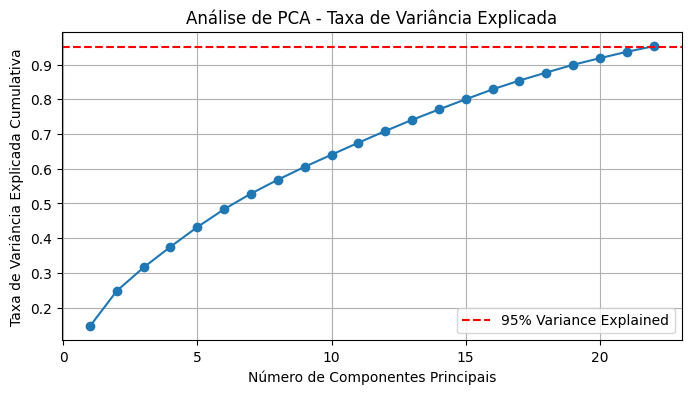

Número de componentes principais selecionados: 22


In [37]:
# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA para reduzir a dimensionalidade
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Calcular a taxa de variância explicada cumulativa
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plotar a taxa de variância explicada
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Explained')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Taxa de Variância Explicada Cumulativa')
plt.title('Análise de PCA - Taxa de Variância Explicada')
plt.grid(True)
plt.legend()
plt.show()

# Selecionar as componentes principais automaticamente com n_components=0.95
print(f"Número de componentes principais selecionados: {pca.n_components_}")

In [38]:
# Aplicar SMOTE para lidar com o desbalanceamento de classes
smote = SMOTE(random_state=42)
X_res, y_res  = smote.fit_resample(X_pca, y)

In [39]:
# Codificação dos dados de treinamento.Configurar o modelo
# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Tokenização dos textos
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', bos_token="[CLS]", eos_token="[SEP]")
train_encodings = tokenizer(list(map(lambda x: ' '.join([str(x) for x in x]), X_train)),
                            truncation=True,
                            padding=True,
                            return_tensors='pt')
train_dataset = torch.utils.data.TensorDataset(train_encodings['input_ids'],
                                               train_encodings['attention_mask'],
                                               torch.tensor(y_train.tolist()))

# Codificação dos dados de teste
test_encodings = tokenizer(list(map(lambda x: ' '.join([str(x) for x in x]), X_test)),
                           truncation=True,
                           padding=True,
                           return_tensors='pt')
test_dataset = torch.utils.data.TensorDataset(test_encodings['input_ids'],
                                              test_encodings['attention_mask'],
                                              torch.tensor(y_test.tolist()))


In [ ]:
# Inicializar o modelo e o tokenizador
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name, bos_token="[CLS]", eos_token="[SEP]")
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Definir o dispositivo de treinamento (GPU ou CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Carregar os dados de treinamento e teste nos objetos train_dataset e test_dataset

# Definir DataLoader para treinamento e teste
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Definir o otimizador e agendamento de taxa de aprendizado
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# Função para treinamento de um único batch
def train_batch(input_ids, attention_mask, labels):
    model.train()
    optimizer.zero_grad()
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Função para avaliação do modelo
def evaluate_model(model, dataloader):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            pred = torch.argmax(logits, axis=1).cpu().numpy()
            true = labels.cpu().numpy()
            y_pred.extend(pred)
            y_true.extend(true)
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Calcular AUC
    y_scores = [logit[1] for logit in logits.cpu().numpy()]
    auc = roc_auc_score(y_true, y_scores)

    return accuracy, precision, recall, f1, auc, cm

# Treinamento do modelo
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        loss = train_batch(input_ids, attention_mask, labels)
        total_loss += loss
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")
    scheduler.step()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5769
Epoch 2/10, Train Loss: 0.4796


In [ ]:
# Avaliação do modelo
accuracy, precision, recall, f1, auc, confusion_matrix = evaluate_model(model, test_dataloader)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(confusion_matrix)

In [ ]:
# Extrair previsões e rótulos verdadeiros
y_pred = []  # Previsões
y_true = []  # Rótulos verdadeiros

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred = torch.argmax(logits, axis=1).cpu().numpy()
        true = labels.cpu().numpy()
        y_pred.extend(pred)
        y_true.extend(true)

# Calcular métricas
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")